# Classify Song Genres from Audio Data

## By-> Gaurav Nagpal

# Project Description
Using a dataset comprised of songs of two music genres (Hip-Hop and Rock), you will train a classifier to distinguish between the two genres based only on track information derived from Echonest (now part of Spotify). You will first make use of pandas and seaborn packages in Python for subsetting the data, aggregating information, and creating plots when exploring the data for obvious trends or factors you should be aware of when doing machine learning. Next, you will use the scikit-learn package to predict whether you can correctly classify a song's genre based on features such as danceability, energy, acousticness, tempo, etc. You will go over implementations of common algorithms such as PCA, logistic regression, decision trees, and so forth.
This project lets you apply what you learned in Supervised Learning with scikit-learn, plus data preprocessing, dimensionality reduction, and machine learning using the scikit-learn package.


# Task

# Preparing our Data Set
Over the past few years, streaming services with huge catalogs have become the primary means through which most people listen to their favorite music. But at the same time, the sheer amount of music on offer can mean users might be a bit overwhelmed when trying to look for newer music that suits their tastes.

For this reason, streaming services have looked into means of categorizing music to allow for personalized recommendations. One method involves direct analysis of the raw audio information in a given song, scoring the raw data on a variety of metrics. Today, we'll be examining data compiled by a research group known as The Echo Nest. Our goal is to look through this dataset and classify songs as being either 'Hip-Hop' or 'Rock' - all without listening to a single one ourselves. In doing so, we will learn how to clean our data, do some exploratory data visualization, and use feature reduction towards the goal of feeding our data through some simple machine learning algorithms, such as decision trees and logistic regression.

To begin with, let's load the metadata about our tracks alongside the track metrics compiled by The Echo Nest. A song is about more than its title, artist, and number of listens. We have another dataset that has musical features of each track such as danceability and acousticness on a scale from -1 to 1. These exist in two different files, which are in different formats - CSV and JSON. While CSV is a popular file format for denoting tabular data, JSON is another common file format in which databases often return the results of a given query.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("fma-rock-vs-hiphop.csv")

In [3]:
df.head()

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky
2,151,192000,0,NaN,2008-11-26 01:44:55,NaN,192,0,Rock,[25],...,NaN,701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,NaN,4,NaN,[],Untitled 04
3,152,192000,0,NaN,2008-11-26 01:44:58,NaN,193,0,Rock,[25],...,NaN,637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,NaN,11,NaN,[],Untitled 11
4,153,256000,0,Arc and Sender,2008-11-26 01:45:00,2008-11-26 00:00:00,405,5,Rock,[26],...,NaN,354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,NaN,2,NaN,[],Hundred-Year Flood


In [5]:
echonest_metrics = pd.read_json('echonest-metrics.json', precise_float=True)

In [6]:
tracks=pd.merge(left=echonest_metrics,right=df[['track_id','genre_top']],on='track_id')
tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
track_id            4802 non-null int64
acousticness        4802 non-null float64
danceability        4802 non-null float64
energy              4802 non-null float64
instrumentalness    4802 non-null float64
liveness            4802 non-null float64
speechiness         4802 non-null float64
tempo               4802 non-null float64
valence             4802 non-null float64
genre_top           4802 non-null object
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


# Pairwise relationships between continuous variables
We typically want to avoid using variables that have strong correlations with each other -- hence avoiding feature redundancy -- for a few reasons:

To keep the model simple and improve interpretability (with many features, we run the risk of overfitting).

When our datasets are very large, using fewer features can drastically speed up our computation time.

To get a sense of whether there are any strongly correlated features in our data, we will use built-in functions in the pandas package.

In [7]:
corr_met=tracks.corr()

In [10]:
print(corr_met)

                  track_id  acousticness  danceability    energy  \
track_id          1.000000     -0.372282      0.049454  0.140703   
acousticness     -0.372282      1.000000     -0.028954 -0.281619   
danceability      0.049454     -0.028954      1.000000 -0.242032   
energy            0.140703     -0.281619     -0.242032  1.000000   
instrumentalness -0.275623      0.194780     -0.255217  0.028238   
liveness          0.048231     -0.019991     -0.106584  0.113331   
speechiness      -0.026995      0.072204      0.276206 -0.109983   
tempo            -0.025392     -0.026310     -0.242089  0.195227   
valence           0.010070     -0.013841      0.473165  0.038603   

                  instrumentalness  liveness  speechiness     tempo   valence  
track_id                 -0.275623  0.048231    -0.026995 -0.025392  0.010070  
acousticness              0.194780 -0.019991     0.072204 -0.026310 -0.013841  
danceability             -0.255217 -0.106584     0.276206 -0.242089  0.473165  

# Normalizing the feature data

As mentioned earlier, it can be particularly useful to simplify our models and use as few features as necessary to achieve the best result. Since we didn't find any particular strong correlations between our features, we can instead use a common approach to reduce the number of features called principal component analysis (PCA).

It is possible that the variance between genres can be explained by just a few features in the dataset. PCA rotates the data along the axis of highest variance, thus allowing us to determine the relative contribution of each feature of our data towards the variance between classes.

However, since PCA uses the absolute variance of a feature to rotate the data, a feature with a broader range of values will overpower and bias the algorithm relative to the other features.

To avoid this, we must first normalize our data. There are a few methods to do this, but a common way is through standardization, such that all features have a mean = 0 and standard deviation = 1 (the resultant is a z-score).

In [11]:
features=tracks.drop(['genre_top','track_id'],axis=1)
labels=tracks['genre_top']

In [12]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_features=scaler.fit_transform(features)

In [13]:
scaled_features

array([[-0.19121034,  1.30442004,  0.03831594, ...,  0.37303429,
         1.15397908,  0.46228696],
       [-0.30603598,  0.50188641,  0.78817624, ...,  2.44615517,
         0.00791367, -0.69081137],
       [-1.20481276,  1.68413943,  0.31285194, ...,  0.13513049,
        -0.77731688,  0.63107745],
       ...,
       [-1.29470431,  1.17682795,  0.13265633, ...,  0.85182206,
        -0.93541008, -0.07941825],
       [-1.13869115, -0.02253433,  0.57117905, ...,  1.40951543,
         1.31301348,  0.47513794],
       [-0.90611434,  1.10148973,  0.56322452, ...,  1.36030881,
        -1.43669053,  0.76217464]])

# Principal Component Analysis on our scaled data

Now that we have preprocessed our data, we are ready to use PCA to determine by how much we can reduce the dimensionality of our data. We can use scree-plots and cumulative explained ratio plots to find the number of components to use in further analyses. 

Scree-plots display the number of components against the variance explained by each component, sorted in descending order of variance. Scree-plots help us get a better sense of which components explain a sufficient amount of variance in our data. 

When using scree plots, an 'elbow' (a steep drop from one data point to the next) in the plot is typically used to decide on an appropriate cutoff

In [14]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(scaled_features)
exp_variance=pca.explained_variance_ratio_

In [15]:
print(pca.explained_variance_ratio_)

[0.24297674 0.18044316 0.13650309 0.12994089 0.11056248 0.08302245
 0.06923783 0.04731336]


In [16]:
print(pca.n_components_)

8


Text(0.5, 0, 'Artists')

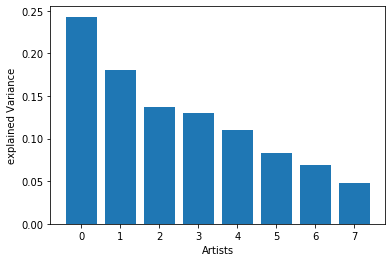

In [18]:
fig,ax=plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_ylabel("explained Variance")
ax.set_xlabel("Artists")

# Further visualization of PCA

Unfortunately, there does not appear to be a clear elbow in this scree plot, which means it is not straightforward to find the number of intrinsic dimensions using this method.

But all is not lost! Instead, we can also look at the cumulative explained variance plot to determine how many features are required to explain, say, about 85% of the variance (cutoffs are somewhat arbitrary here, and usually decided upon by 'rules of thumb'). 

Once we determine the appropriate number of components, we can perform PCA with that many components, ideally reducing the dimensionality of our data.

In [19]:
cum_exp_variance=np.cumsum(exp_variance)

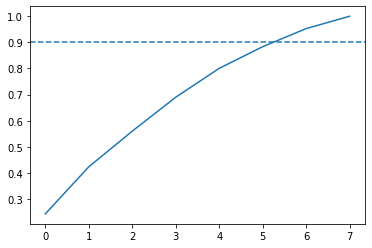

In [20]:
fig,ax=plt.subplots()
ax.plot(range(pca.n_components_),cum_exp_variance)
ax.axhline(y=0.9,linestyle='--')
n_components=6

In [21]:
pca=PCA(n_components)
pca.fit(scaled_features)
pca_projection=pca.transform(scaled_features)

# Train a decision tree to classify genre

Now we can use the lower dimensional PCA projection of the data to classify songs into genres. To do that, we first need to split our dataset into 'train' and 'test' subsets, where the 'train' subset will be used to train our model while the 'test' dataset allows for model performance validation.

Here, we will be using a simple algorithm known as a decision tree. Decision trees are rule-based classifiers that take in features and follow a 'tree structure' of binary decisions to ultimately classify a data point into one of two or more categories. In addition to being easy to both use and interpret, decision trees allow us to visualize the 'logic flowchart' that the model generates from the training data.

Here is an example of a decision tree that demonstrates the process by which an input image (in this case, of a shape) might be classified based on the number of sides it has and whether it is rotated.



# 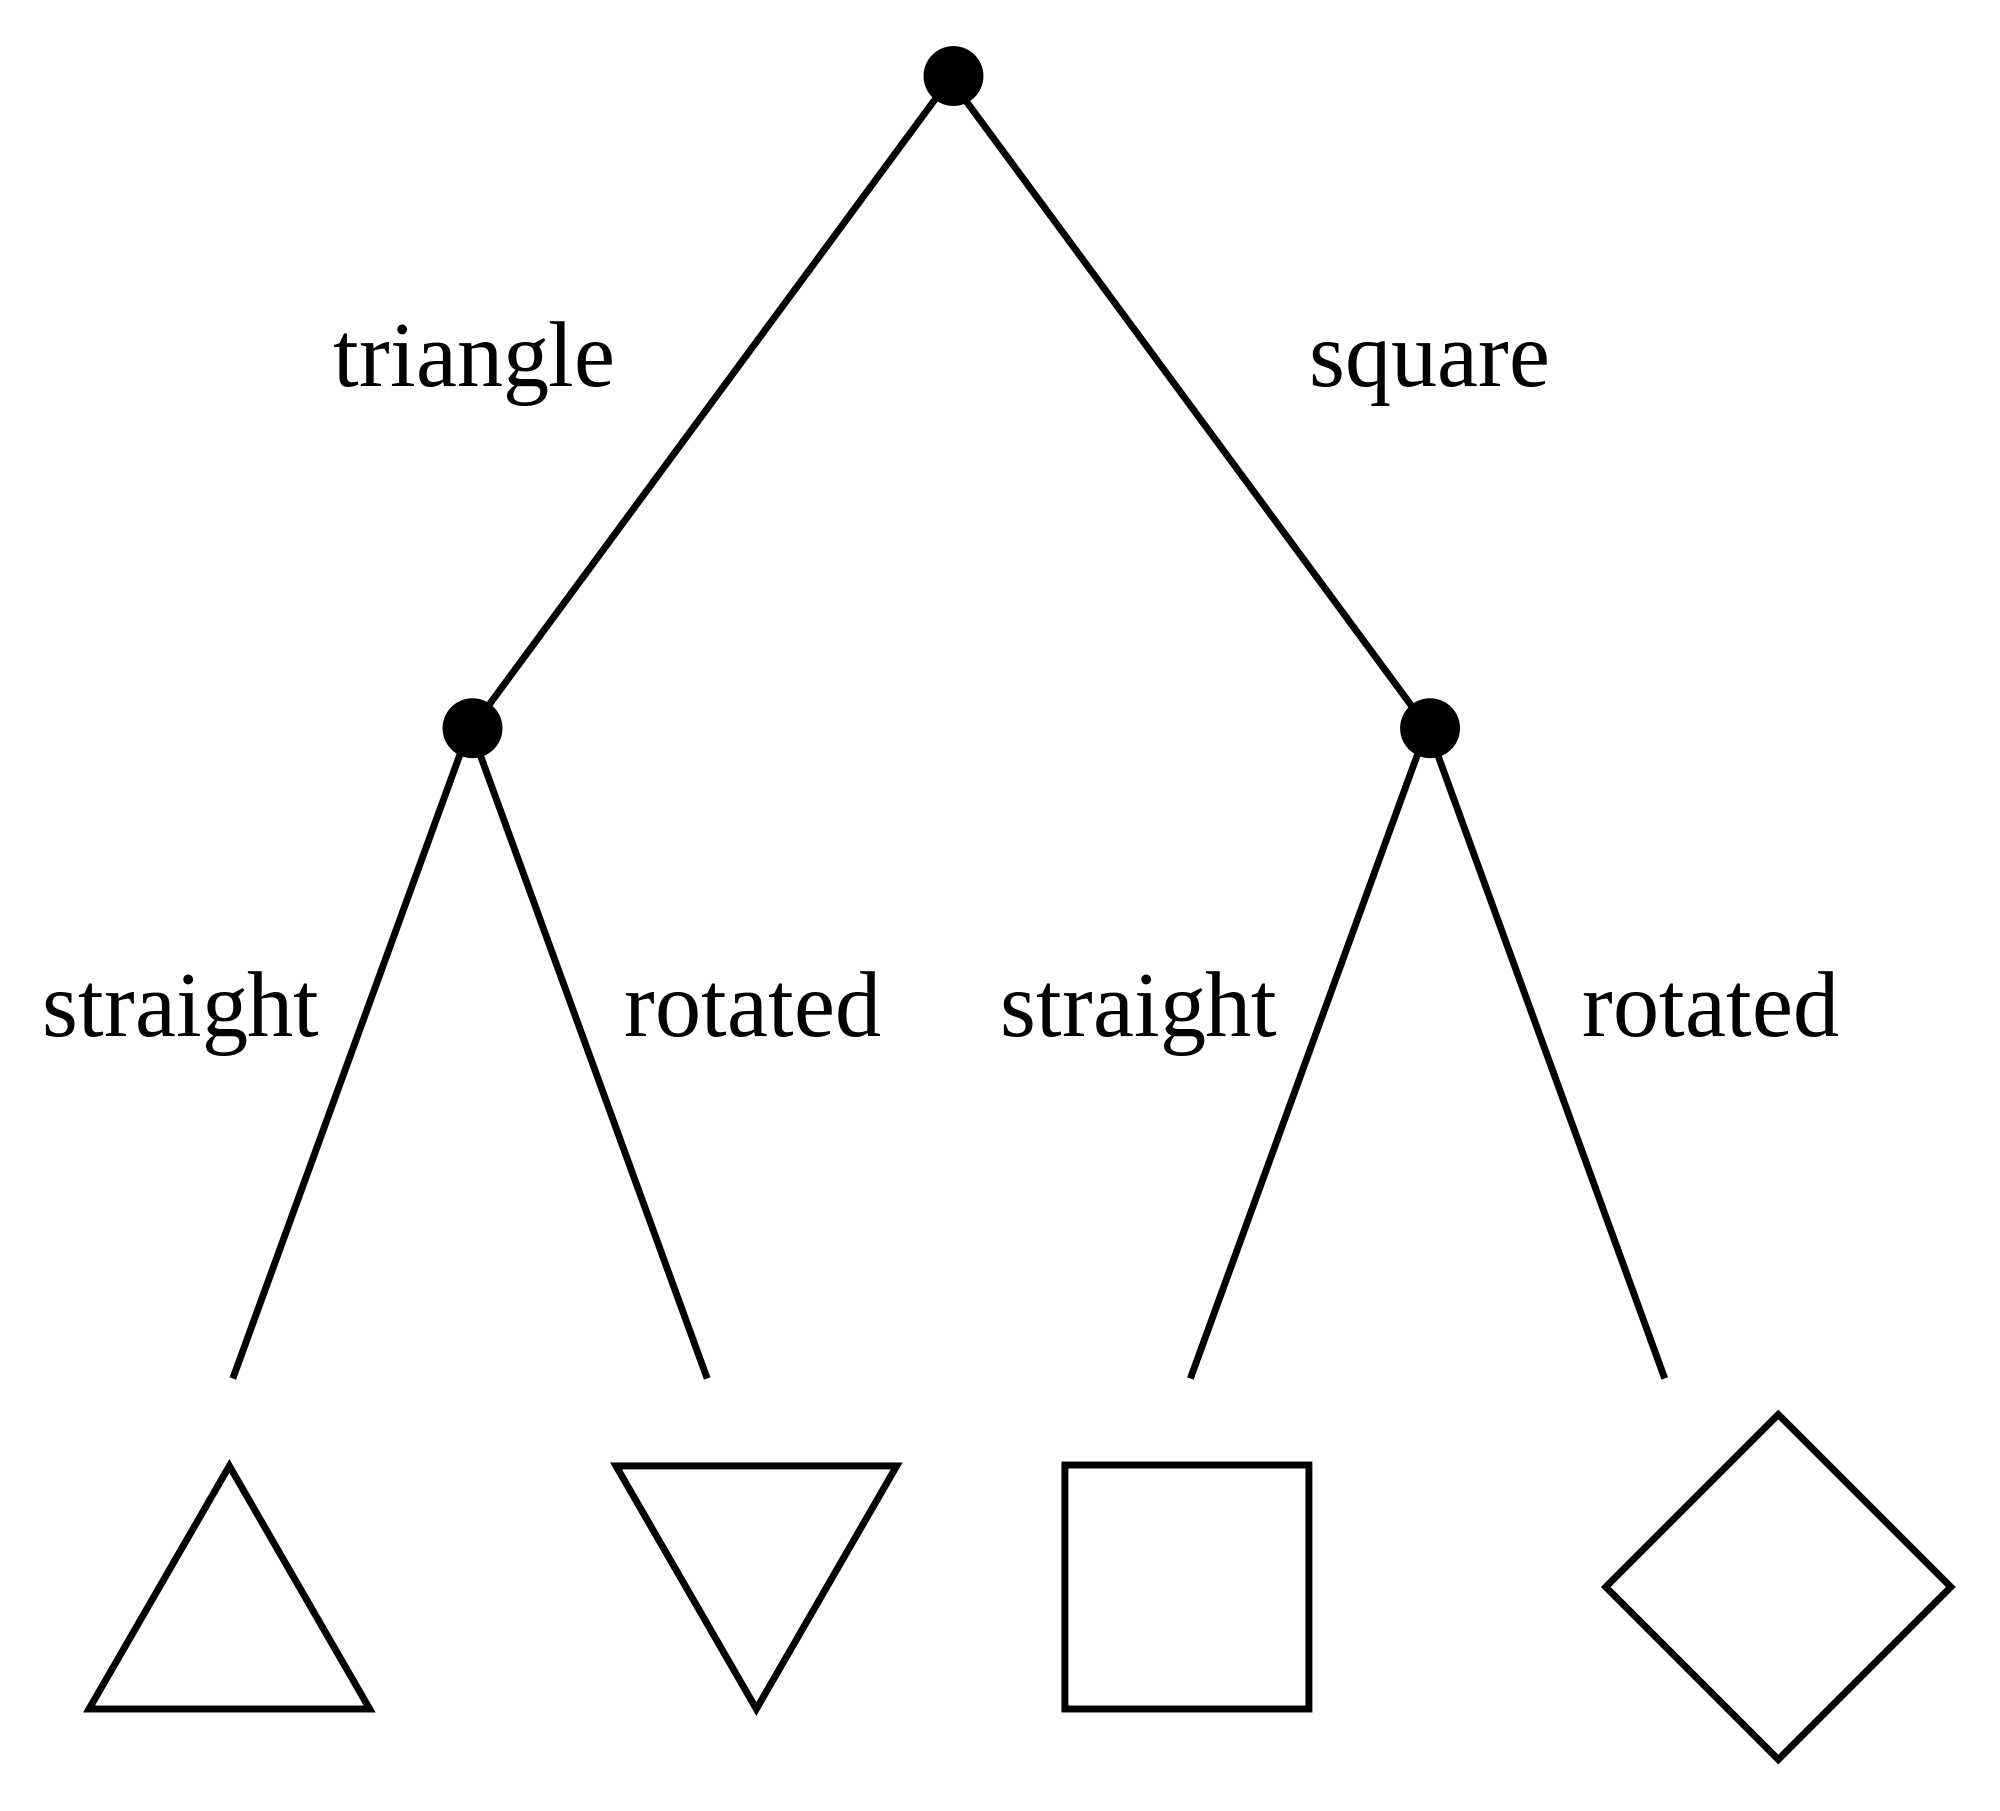

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


In [25]:
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels)

In [26]:
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=10, splitter='best')

In [27]:
pred_labels_tree=tree.predict(test_features)

In [28]:
pred_labels_tree

array(['Rock', 'Hip-Hop', 'Rock', ..., 'Hip-Hop', 'Rock', 'Rock'],
      dtype=object)

# Compare our decision tree to a logistic Regression

Although our tree's performance is decent, it's a bad idea to immediately assume that it's therefore the perfect tool for this job -- there's always the possibility of other models that will perform even better! It's always a worthwhile idea to at least test a few other algorithms and find the one that's best for our data.

Sometimes simplest is best, and so we will start by applying logistic regression. Logistic regression makes use of what's called the logistic function to calculate the odds that a given data point belongs to a given class. Once we have both models, we can compare them on a few performance metrics, such as false positive and false negative rate (or how many points are inaccurately classified).


In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
logreg=LogisticRegression()

In [31]:
logreg.fit(train_features,train_labels)
pred_labels_logit=logreg.predict(test_features)


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [33]:
pred_labels_logit

array(['Rock', 'Hip-Hop', 'Rock', ..., 'Rock', 'Rock', 'Rock'],
      dtype=object)

In [36]:
from sklearn.metrics import classification_report
class_rep_tree=classification_report(test_labels,pred_labels_tree)
class_rep_log=classification_report(test_labels,pred_labels_logit)

In [37]:
print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.58      0.62      0.60       230
        Rock       0.91      0.89      0.90       971

    accuracy                           0.84      1201
   macro avg       0.74      0.76      0.75      1201
weighted avg       0.85      0.84      0.84      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.51      0.61       230
        Rock       0.89      0.96      0.93       971

    accuracy                           0.88      1201
   macro avg       0.83      0.74      0.77      1201
weighted avg       0.87      0.88      0.87      1201



# Balance our data for greater performance

Both our models do similarly well, boasting an average precision of 87% each. However, looking at our classification report, we can see that rock songs are fairly well classified, but hip-hop songs are disproportionately misclassified as rock songs.

Why might this be the case? Well, just by looking at the number of data points we have for each class, we see that we have far more data points for the rock classification than for hip-hop, potentially skewing our model's ability to distinguish between classes. This also tells us that most of our model's accuracy is driven by its ability to classify just rock songs, which is less than ideal.

To account for this, we can weight the value of a correct classification in each class inversely to the occurrence of data points for each class. Since a correct classification for "Rock" is not more important than a correct classification for "Hip-Hop" (and vice versa), we only need to account for differences in sample size of our data points when weighting our classes here, and not relative importance of each class.

In [53]:
hop_only = tracks.loc[tracks['genre_top']=='Hip-Hop']
rock_only = tracks.loc[tracks['genre_top']=='Rock']

In [52]:
rock_only = rock_only.sample(len(hop_only), random_state=10)
rock_hop_bal = pd.concat([rock_only, hop_only])

In [54]:
rock_hop_bal


,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
3451,41808,0.118882,0.343670,0.980253,1.586773e-02,0.406901,0.221571,85.285,0.123154,Rock
4310,69264,0.000200,0.303582,0.949881,7.144992e-01,0.184021,0.051143,135.600,0.279924,Rock
637,3621,0.822050,0.449377,0.475488,6.511887e-01,0.095845,0.057139,168.386,0.535927,Rock
4175,59876,0.472701,0.449648,0.670768,8.817601e-01,0.376850,0.032769,84.139,0.295328,Rock
4473,82910,0.005984,0.581709,0.655618,1.801006e-03,0.118425,0.032335,123.496,0.775903,Rock
...,...,...,...,...,...,...,...,...,...,...
4797,124718,0.412194,0.686825,0.849309,6.000000e-10,0.867543,0.367315,96.104,0.692414,Hip-Hop
4798,124719,0.054973,0.617535,0.728567,7.215700e-06,0.131438,0.243130,96.262,0.399720,Hip-Hop
4799,124720,0.010478,0.652483,0.657498,7.098000e-07,0.701523,0.229174,94.885,0.432240,Hip-Hop
4800,124721,0.067906,0.432421,0.764508,1.625500e-06,0.104412,0.310553,171.329,0.580087,Hip-Hop


In [55]:
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))
train_features, test_features, train_labels,test_labels = train_test_split(pca_projection, labels, random_state=10)

# Does balancing our dataset improve model bias?

We've now balanced our dataset, but in doing so, we've removed a lot of data points that might have been crucial to training our models. Let's test to see if balancing our data improves model bias towards the "Rock" classification while retaining overall classification performance.

Note that we have already reduced the size of our dataset and will go forward without applying any dimensionality reduction. In practice, we would consider dimensionality reduction more rigorously when dealing with vastly large datasets and when computation times become prohibitively large.

In [56]:
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

In [57]:
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [58]:
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.78      0.74      0.76       230
        Rock       0.75      0.78      0.77       225

    accuracy                           0.76       455
   macro avg       0.76      0.76      0.76       455
weighted avg       0.76      0.76      0.76       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.80      0.81       230
        Rock       0.80      0.83      0.81       225

    accuracy                           0.81       455
   macro avg       0.81      0.81      0.81       455
weighted avg       0.81      0.81      0.81       455



# Using cross-validation to evaluate our models

## Success! 

Balancing our data has removed bias towards the more prevalent class. To get a good sense of how well our models are actually performing, we can apply what's called cross-validation (CV). This step allows us to compare models in a more rigorous fashion.

Since the way our data is split into train and test sets can impact model performance, CV attempts to split the data multiple ways and test the model on each of the splits. Although there are many different CV methods, all with their own advantages and disadvantages, we will use what's known as K-fold CV here. K-fold first splits the data into K different, equally sized subsets. 

Then, it iteratively uses each subset as a test set while using the remainder of the data as train sets. Finally, we can then aggregate the results from each fold for a final model performance score.

In [59]:
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=10, random_state=10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

In [63]:
tree_score = cross_val_score(tree, pca_projection, labels, cv=kf)
logit_score = cross_val_score(logreg, pca_projection, labels, cv=kf)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

In [64]:
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.7554945054945055 Logistic Regression: 0.784065934065934
